# First PROTOTYPE

In [1]:
import os
from dotenv import  load_dotenv
from openai  import OpenAI
import anthropic
from IPython.display import Markdown, display, update_display
import gradio as gr
import json
from pydub import AudioSegment
from pydub.playback import play
# Some imports for handling images

import base64
from io import BytesIO
from PIL import Image

In [2]:
load_dotenv()
openai_api_key = os.getenv('OPENAI_API_KEY')
anthropic_api_key = os.getenv('ANTHROPIC_API_KEY')

openai = OpenAI()
claude = anthropic.Anthropic()

In [46]:
ticket_prices = {
    "london": "$799",
    "paris": "$899",
    "tokyo": "$1400",
    "berlin": "$499",
    "new_york": "$650",
    "los_angeles": "$750",
    "sydney": "$1600",
    "dubai": "$1200",
    "rome": "$850",
    "singapore": "$1300",
    "toronto": "$700",
    "bangkok": "$1100",
    "madrid": "$780",
    "hong_kong": "$1250",
    "amsterdam": "$820",
    "istanbul": "$950",
    "seoul": "$1350",
    "cairo": "$880",
    "rio_de_janeiro": "$980",
    "cape_town": "$1450",
    "beijing": "$1380",
    "mexico_city": "$900",
    "buenos_aires": "$1050",
    "moscow": "$1200",
    "vienna": "$830",
    "lisbon": "$810",
    "são_paulo": "$1020",
    "prague": "$790",
    "stockholm": "$860",
    "helsinki": "$870",
    "oslo": "$890",
    "budapest": "$740",
    "warsaw": "$720",
    "brussels": "$805",
    "zurich": "$880",
    "geneva": "$895",
    "athens": "$910",
    "jakarta": "$1250",
    "manila": "$1220",
    "kuala_lumpur": "$1180",
    "taipei": "$1280",
    "ho_chi_minh_city": "$1120",
    "hanoi": "$1110",
    "mumbai": "$1150",
    "delhi": "$1170",
    "bangalore": "$1190",
    "chennai": "$1160",
    "santiago": "$1080",
    "bogota": "$980",
    "lima": "$970",
    "auckland": "$1650",
    "nairobi": "$1320",
    "lagos": "$1400",
    "doha": "$1250",
    "riyadh": "$1275"
}

cities = list(ticket_prices.keys())

In [99]:
gpt_system = "You are a helpful AI assistant working for a travel agency. \
You assist customers with booking tickets,and knowing the flight prices. short conversation, only answer 2 questions. start with short greeting"
claude_system = (
    f"You are a curious customer who wants to travel and get ticket price information. "
    f"Pick **one random city** from this list: {', '.join(cities)}. "
    "Directly ask for the ticket price for that city. "
    "Do not say you're choosing or picking a city. "
    "You only ask 2 questions and do not mention another city. Keep it natural and short."
)

# gpt_messages = ["Hello!"]
# claude_messages = ["Hi!"]

In [100]:
def get_ticket_price(destination_city):
    print(f"Tool get_ticket_price called for {destination_city}")
    city = destination_city.lower()
    return ticket_prices.get(city, "Unknown")

In [101]:
# There's a particular dictionary structure that's required to describe our function:

price_function = {
    "name": "get_ticket_price",
    "description": "Get the price of a return ticket to the destination city. Call this whenever you need to know the ticket price, for example when a customer asks 'How much is a ticket to this city'",
    "parameters": {
        "type": "object",
        "properties": {
            "destination_city": {
                "type": "string",
                "description": "The city that the customer wants to travel to",
            },
        },
        "required": ["destination_city"],
        "additionalProperties": False
    }
}

In [102]:
tools = [{"type": "function", "function": price_function}]

In [103]:
def handle_tool_call(message):
    tool_call = message.tool_calls[0]
    arguments = json.loads(tool_call.function.arguments)
    print(arguments)
    city = arguments.get('destination_city')
    price = get_ticket_price(city)
    print('gfbgfn')
    response = {
        "role": "tool",
        "content": json.dumps({"destination_city": city,"price": price}),
        "tool_call_id": tool_call.id
    }
    return response, city

In [104]:
def artist(city):
    image_response = openai.images.generate(
        model='dall-e-3',
        prompt=f"An image representing a vacation in {city}, showing tourist spots and everything unique about {city}, in a vibrant pop-art style",
            size="1024x1024",
            n=1,
            response_format="b64_json",
        )
    
    image_base64 = image_response.data[0].b64_json
    image_data = base64.b64decode(image_base64)
    return Image.open(BytesIO(image_data))

In [105]:


def talker_claude(message):
    response = openai.audio.speech.create(
      model="tts-1",
      voice="onyx",    # Also, try replacing onyx with alloy
      input=message
    )
    
    audio_stream = BytesIO(response.content)
    audio = AudioSegment.from_file(audio_stream, format="mp3")
    play(audio)

def talker_gpt(message):
    response = openai.audio.speech.create(
      model="tts-1",
      voice="alloy",    # Also, try replacing onyx with alloy
      input=message
    )
    
    audio_stream = BytesIO(response.content)
    audio = AudioSegment.from_file(audio_stream, format="mp3")
    play(audio)
    
  

In [106]:
# def call_gpt(message, history):
#     messages = [{"role": "system", "content": gpt_system}] + history + [{"role": "user", "content": message}]
    
#     MODEL = "gpt-4o--mini" 
    
#     response = openai.chat.completions.create(
#         model=MODEL,
#         messages=messages,
#         tools=tools
#     )

#     image = None  # Placeholder for image response

#     if response.choices[0].finish_reason == 'tool_calls':
#         tool_message = response.choices[0].message
#         tool_response, city = handle_tool_call(tool_message)

#         # Append both the tool request and its response
#         messages.append(tool_message)
#         messages.append(tool_response)

#         # Generate an image for the requested city
#         image = artist(city)

#         # Call GPT again to process the tool response
#         response = openai.chat.completions.create(
#             model=MODEL,
#             messages=messages
#         )

#     reply = response.choices[0].message.content
#     history.append({"role": "assistant", "content": reply})

#     talker_claude(reply)  # Send GPT's response to Claude

#     return history, image, ""

In [107]:


# def call_claude(history, message):
#     messages = history + [{"role": "user", "content": message}]

#     completion = claude.messages.create(
#         model="claude-3-haiku-20240307",
#         system=claude_system,  # Pass system prompt here
#         messages=messages,
#         max_tokens=500
#     )

#     reply = completion.content
#     history.append({"role": "assistant", "content": reply})

#     talker_gpt(reply)

#     return history, reply

In [108]:
# import gradio as gr

# def start_conversation():
#     claude_history = []
#     gpt_history = []
#     conversation_log = ""
#     image_outputs = []

#     message = "Hi!"

#     for turn in range(8):
#         claude_history, claude_reply = call_claude(claude_history, message)
#         conversation_log += f"🧑 Claude: {claude_reply}\n\n"

#         gpt_history, image, gpt_reply = call_gpt(claude_reply, gpt_history)
#         conversation_log += f"🤖 GPT: {gpt_reply}\n\n"

#         message = gpt_reply

#         if image:
#             image_outputs.append(image)

#     return conversation_log, image_outputs[-1] if image_outputs else None
# # Build the interface
# with gr.Blocks() as demo:
#     gr.Markdown("## 🤖 Claude & GPT Travel Chat")
    
#     start_btn = gr.Button("Start Conversation")
#     chat_output = gr.Textbox(label="Conversation", lines=30)
#     image_output = gr.Image(label="Last Generated Travel Image", type="pil")

#     start_btn.click(start_conversation, outputs=[chat_output, image_output])

# demo.launch()

In [109]:
# def chat(message,history):
#     messages = [{"role": "system", "content": system_message}] + history +  [{"role":"user", "content":message}]
#     response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)
#     image = None

#     if response.choices[0].finish_reason == 'tool_calls':
#         message  = response.choices[0].message
#         response,city = handle_tool_call(message)
#         messages.append(message)
#         messages.append(response)
#         image = artist(city)

#         response = openai.chat.completions.create(model=MODEL, messages=messages)
#     reply = response.choices[0].message.content
#     history += [{"role":"assistant", "content":reply}]
#     talker_claude(reply)

#     return history,image,""


In [110]:
	
# gpt_messages = ["Hi there"]
# claude_messages = ["Hi"]

# print(f"GPT:\n{gpt_messages[0]}\n")
# print(f"Claude:\n{gpt_messages[0]}\n")


# for i in range(5):
#     gpt_next = call_gpt()
#     print(f"GPT:\n{gpt_next}\n")
#     gpt_messages.append(gpt_next)


#     claude_next = call_claude()
#     print(f"Claude:\n{claude_next}\n")
#     claude_messages.append(claude_next)

In [111]:
# with gr.Blocks() as ui:
#     with gr.Row():
#         chatbot = gr.Chatbot(height=500 , type='messages') #gpt
#         image_output = gr.Image(height=500)

#     with gr.Row():
#         entry = gr.Textbox(label = 'chat with AI') #claude
#         with gr.Row():
#             clear = gr.Button('clear')
#         entry.submit(call_gpt, [entry, chatbot], [chatbot, image_output,entry]).then(
#                     call_claude, [chatbot, ]
#         )
#         clear.click(lambda: None, inputs=None, outputs=chatbot, queue=False)
# ui.launch()


In [112]:
# def call_claude(history, message):
#     messages = [{"role": "system", "content": claude_system}] + history + [{"role": "user", "content": message}]
    
#     completion = claude.messages.create(
#         model='claude-3-haiku-20240307',
#         messages=messages,
#         system=claude_system,
#         max_tokens=500,
#     )

#     reply = completion.choices[0].message.content
#     history.append({"role": "assistant", "content": reply})
    
#     talker_claude(reply)
#     return history, reply  # Update chatbot & entry with Claude's reply


# def call_gpt(message, history):
#     messages = [{"role": "system", "content": gpt_system}] + history + [{"role": "user", "content": message}]
    
#     response = openai.chat.completions.create(model='gpt-4o-mini', messages=messages, tools=tools)
#     image = None

#     if response.choices[0].finish_reason == 'tool_calls':
#         message = response.choices[0].message
#         response, city = handle_tool_call(message)
#         messages.append({"role": "assistant", "content": response})
#         image = artist(city)

#         response = openai.chat.completions.create(model=MODEL, messages=messages)

#     reply = response.choices[0].message.content
#     history.append({"role": "assistant", "content": reply})
    
#     talker_gpt(reply)
#     return history, image, reply  # Update chatbot, image, and pass reply to Claude

In [113]:
# def call_claude(history):
#     # Prepare messages - exclude system role from messages list
#     messages = []
#     for msg in history:
#         # Convert "system" messages to "user" messages for Claude
#         role = "user" if msg["role"] == "system" else msg["role"]
#         messages.append({"role": role, "content": msg["content"]})
    
#     completion = claude.messages.create(
#         model='claude-3-haiku-20240307',
#         messages=messages,
#         system=claude_system,  # System message passed separately
#         max_tokens=500,
#     )
    
#     reply = completion.content[0].text
#     updated_history = list(history) + [{"role": "assistant", "content": reply}]
    
#     talker_claude(reply)  # Your voice function
#     return updated_history, reply


# def call_gpt(history):
#     # Prepare messages - include system message at start if history is empty
#     messages = [{"role": "system", "content": gpt_system}] if not history else []
#     messages += list(history)
    
#     response = openai.chat.completions.create(
#         model='gpt-4o-mini',
#         messages=messages,
#         tools=tools
#     )
    
#     reply = response.choices[0].message.content
#     image = None
    
#     if response.choices[0].message.tool_calls:
#         tool_call = response.choices[0].message.tool_calls[0]
#         reply, city = handle_tool_call(tool_call)
#         image = artist(city)
    
#     updated_history = list(history) + [{"role": "assistant", "content": reply}]
    
#     talker_gpt(reply)  # Your voice function
#     return updated_history, image, reply


# # with gr.Blocks() as ui:
# #     history = gr.State([])
    
# #     with gr.Row():
# #         chatbot = gr.Chatbot(height=500)
# #         image_output = gr.Image(height=500)
    
# #     start_btn = gr.Button("Start Conversation")
    
# #     def start_conversation(history):
# #         # Initialize with Claude's system message as first user message
# #         history = [{"role": "user", "content": claude_system}]
        
# #         # Claude speaks first
# #         history, claude_reply = call_claude(history)
# #         chat_history = [(claude_reply, "")]
        
# #         # GPT responds
# #         history, image, gpt_reply = call_gpt(history)
# #         chat_history[-1] = (claude_reply, gpt_reply)
        
# #         return history, chat_history, image
    
# #     start_btn.click(
# #         start_conversation,
# #         inputs=[history],
# #         outputs=[history, chatbot, image_output]
# #     )

# # ui.launch()

In [114]:
# import gradio as gr

# history = []  # list of {"role": ..., "content": ...}

# def start_conversation():
#     global history
#     history = []  # reset
#     msg = "Hi! I'm planning a trip and need your advice."
#     history.append({"role": "user", "content": msg})  # Claude starts
#     return format_for_gradio(history), None

# def next_turn():
#     global history

#     # Claude replies
#     history, claude_reply = call_claude(history, history[-1]["content"])
#     history.append({"role": "assistant", "content": claude_reply})

#     # GPT replies
#     history, image, gpt_reply = call_gpt(claude_reply, history)
#     history.append({"role": "assistant", "content": gpt_reply})

#     return format_for_gradio(history), image

# def format_for_gradio(history):
#     gr_history = []
#     last_user = None
#     for msg in history:
#         if msg["role"] == "user":
#             last_user = msg["content"]
#         elif msg["role"] == "assistant":
#             gr_history.append([last_user, msg["content"]])
#             last_user = None
#     return gr_history

# with gr.Blocks() as ui:
#     gr.Markdown("### Claude (Customer) & GPT (Assistant)")

#     with gr.Row():
#         chatbot = gr.Chatbot(height=500)
#         image_output = gr.Image(height=500)

#     with gr.Row():
#         start_btn = gr.Button("Start Conversation")
#         next_btn = gr.Button("Next Turn")

#     start_btn.click(start_conversation, outputs=[chatbot, image_output])
#     next_btn.click(next_turn, outputs=[chatbot, image_output])

# ui.launch()

In [115]:
MODEL= 'gpt-4o-mini'
def call_gpt(history):
    # messages_gpt = [{"role": "system", "content": gpt_system}] + history[-1]
    # print('history', history)
    response = openai.chat.completions.create(model='gpt-4o-mini', messages=history,tools=tools)
    image = None
    messages = history.copy()
    if response.choices[0].finish_reason=="tool_calls":
        message = response.choices[0].message
        response, city = handle_tool_call(message)
        messages.append(message)
        messages.append(response)
        image = artist(city)
        history.extend(messages)
        response = openai.chat.completions.create(model=MODEL, messages=history)
        
    reply = response.choices[0].message.content
    # history.append({"role":"assistant", "content":reply})

    # Comment out or delete the next line if you'd rather skip Audio for now..
    talker_gpt(reply)

    return image, history, reply

In [116]:
def call_claude(history):
    # messages = []
    completion = claude.messages.create(
        model="claude-3-haiku-20240307",
        system=claude_system,  # Pass system prompt here
        messages=history,
        max_tokens=500
    )

    message = completion.content[0].text
    # history.append({"role": "assistant", "content": message})

    talker_claude(message)

    return message

In [117]:
def conversation():

    gpt_history = [{"role": "system", "content": gpt_system}]
    claude_history = []
    image = []
    for i in range(3):
        print('gpt_ history', gpt_history)
        image,gpt_history,gpt_next = call_gpt(gpt_history)
        if image:
            display(image)
        print(f"GPT:\n{gpt_next}\n")
        gpt_history.append({'role':'assistant', 'content':gpt_next})
        claude_history.append({'role':'user', 'content':gpt_next})
        # print("gpt_history: ",gpt_history)
        print("claude_history: ",claude_history)

        claude_next = call_claude(claude_history)
        print(f"Claude:\n{claude_next}\n")
        
        gpt_history.append({'role':'user', 'content':claude_next})
        claude_history.append({'role':'assistant', 'content':claude_next})
        # print('claude_history',claude_history)


gpt_ history [{'role': 'system', 'content': 'You are a helpful AI assistant working for a travel agency. You assist customers with booking tickets,and knowing the flight prices. short conversation, only answer 2 questions. start with short greeting'}]


Input #0, wav, from '/var/folders/v9/yz64p8z5579c6d6yx28446qh0000gn/T/tmp094p03g3.wav':
  Duration: 00:00:03.41, bitrate: 384 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 24000 Hz, 1 channels, s16, 384 kb/s



GPT:
Hello! How can I assist you with your travel plans today?

claude_history:  [{'role': 'user', 'content': 'Hello! How can I assist you with your travel plans today?'}]


Input #0, wav, from '/var/folders/v9/yz64p8z5579c6d6yx28446qh0000gn/T/tmpigw0fqz3.wav':
  Duration: 00:00:03.31, bitrate: 384 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 24000 Hz, 1 channels, s16, 384 kb/s



Claude:
Hi, I'd like to know the ticket price to travel to Tokyo.

gpt_ history [{'role': 'system', 'content': 'You are a helpful AI assistant working for a travel agency. You assist customers with booking tickets,and knowing the flight prices. short conversation, only answer 2 questions. start with short greeting'}, {'role': 'assistant', 'content': 'Hello! How can I assist you with your travel plans today?'}, {'role': 'user', 'content': "Hi, I'd like to know the ticket price to travel to Tokyo."}]
{'destination_city': 'Tokyo'}
Tool get_ticket_price called for Tokyo
gfbgfn


Input #0, wav, from '/var/folders/v9/yz64p8z5579c6d6yx28446qh0000gn/T/tmp_gvzghii.wav':
  Duration: 00:00:05.45, bitrate: 384 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 24000 Hz, 1 channels, s16, 384 kb/s


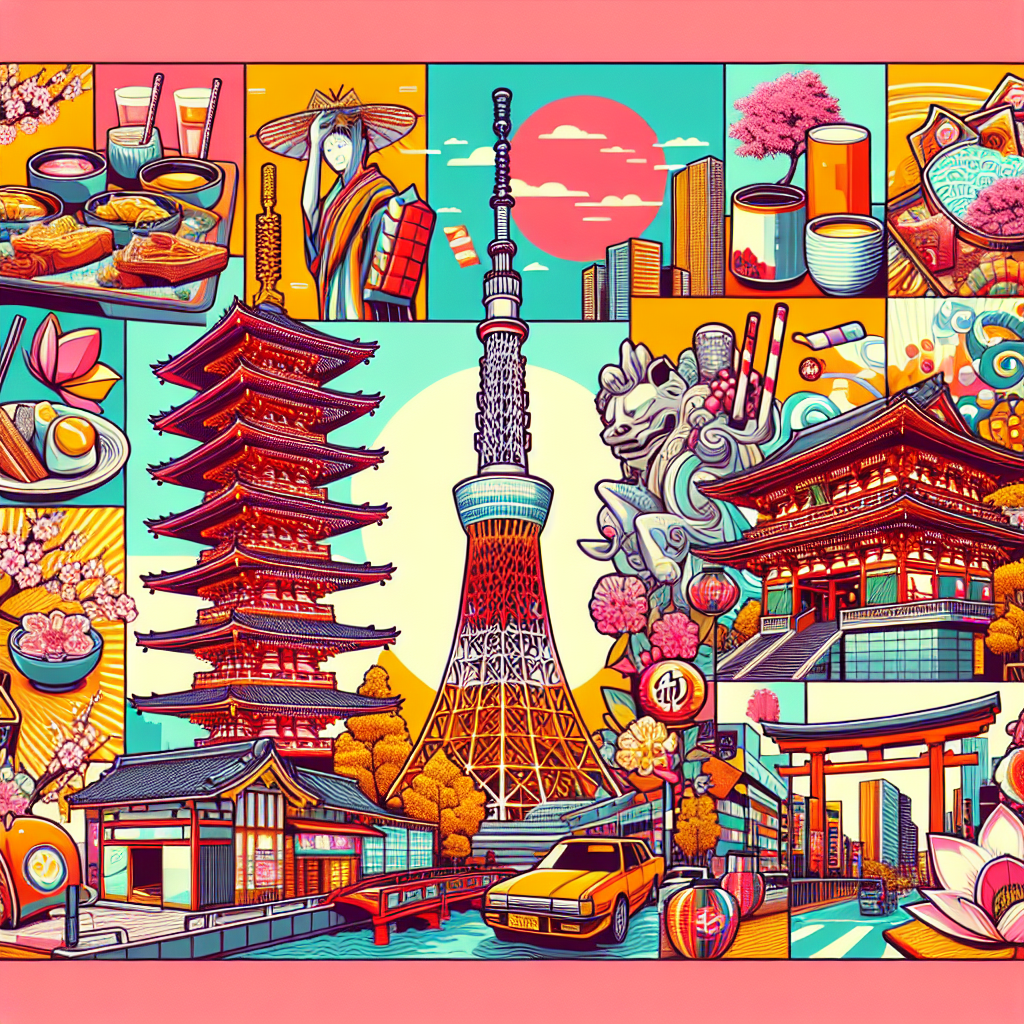

GPT:
The ticket price to travel to Tokyo is $1400. Do you have any other questions?

claude_history:  [{'role': 'user', 'content': 'Hello! How can I assist you with your travel plans today?'}, {'role': 'assistant', 'content': "Hi, I'd like to know the ticket price to travel to Tokyo."}, {'role': 'user', 'content': 'The ticket price to travel to Tokyo is $1400. Do you have any other questions?'}]


Input #0, wav, from '/var/folders/v9/yz64p8z5579c6d6yx28446qh0000gn/T/tmpwm9vzz6n.wav':
  Duration: 00:00:04.22, bitrate: 384 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 24000 Hz, 1 channels, s16, 384 kb/s



Claude:
Oh, that's helpful. And what would the ticket price be to travel to Berlin?

gpt_ history [{'role': 'system', 'content': 'You are a helpful AI assistant working for a travel agency. You assist customers with booking tickets,and knowing the flight prices. short conversation, only answer 2 questions. start with short greeting'}, {'role': 'assistant', 'content': 'Hello! How can I assist you with your travel plans today?'}, {'role': 'user', 'content': "Hi, I'd like to know the ticket price to travel to Tokyo."}, {'role': 'system', 'content': 'You are a helpful AI assistant working for a travel agency. You assist customers with booking tickets,and knowing the flight prices. short conversation, only answer 2 questions. start with short greeting'}, {'role': 'assistant', 'content': 'Hello! How can I assist you with your travel plans today?'}, {'role': 'user', 'content': "Hi, I'd like to know the ticket price to travel to Tokyo."}, ChatCompletionMessage(content=None, refusal=None, role

Input #0, wav, from '/var/folders/v9/yz64p8z5579c6d6yx28446qh0000gn/T/tmp53xoatid.wav':
  Duration: 00:00:06.17, bitrate: 384 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 24000 Hz, 1 channels, s16, 384 kb/s


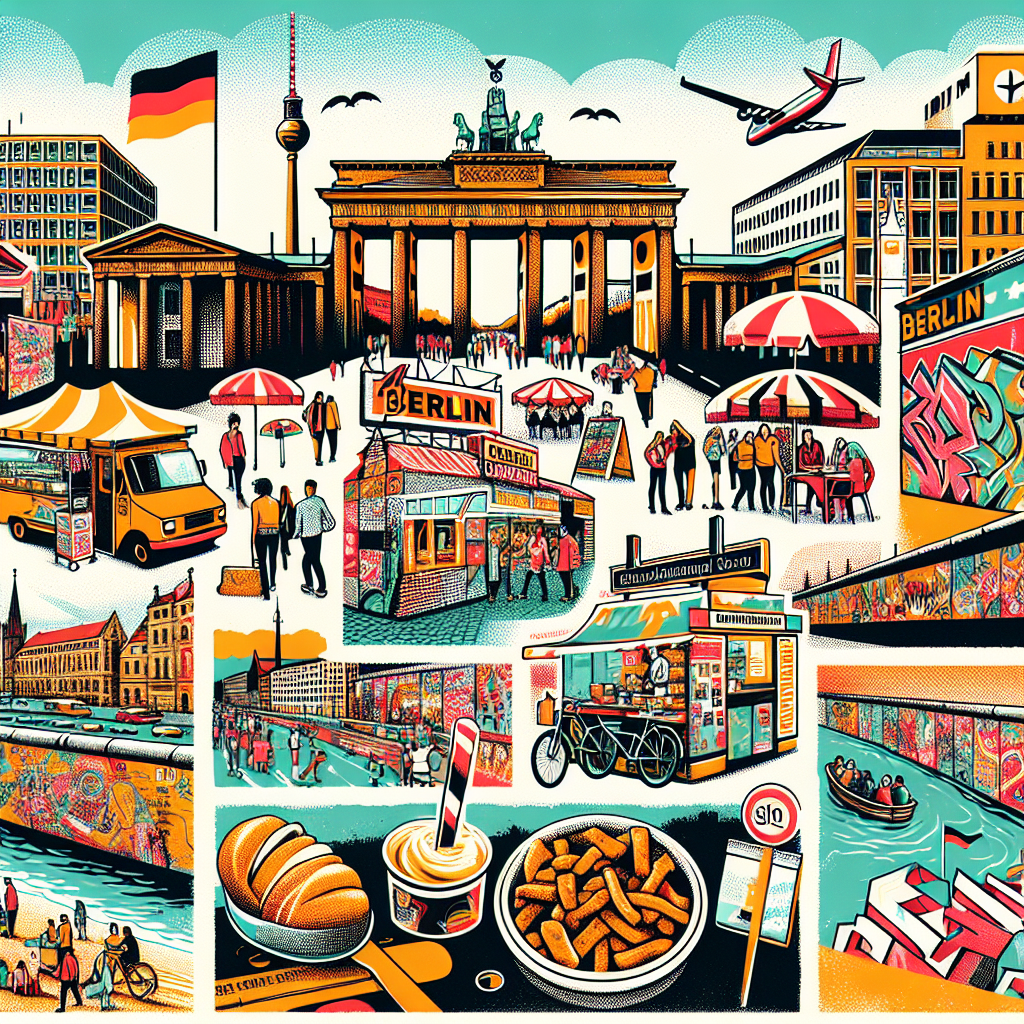

GPT:
The ticket price to travel to Berlin is $499. If you need anything else, just let me know!

claude_history:  [{'role': 'user', 'content': 'Hello! How can I assist you with your travel plans today?'}, {'role': 'assistant', 'content': "Hi, I'd like to know the ticket price to travel to Tokyo."}, {'role': 'user', 'content': 'The ticket price to travel to Tokyo is $1400. Do you have any other questions?'}, {'role': 'assistant', 'content': "Oh, that's helpful. And what would the ticket price be to travel to Berlin?"}, {'role': 'user', 'content': 'The ticket price to travel to Berlin is $499. If you need anything else, just let me know!'}]


Input #0, wav, from '/var/folders/v9/yz64p8z5579c6d6yx28446qh0000gn/T/tmp6kjipvqo.wav':
  Duration: 00:00:05.59, bitrate: 384 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 24000 Hz, 1 channels, s16, 384 kb/s



Claude:
Okay, great. That gives me a good idea of the prices. Thank you for your help, I appreciate it.

None


In [118]:


print(conversation())

In [123]:
def conversation():
    gpt_history = [{"role": "system", "content": gpt_system}]
    claude_history = []
    image = None
    log = ""

    for i in range(3):
        image, gpt_history, gpt_next = call_gpt(gpt_history)
        log += f"🤖 GPT: {gpt_next}\n\n"

        gpt_history.append({'role': 'assistant', 'content': gpt_next})
        claude_history.append({'role': 'user', 'content': gpt_next})

        claude_next = call_claude(claude_history)
        log += f"🧑 Claude: {claude_next}\n\n"

        gpt_history.append({'role': 'user', 'content': claude_next})
        claude_history.append({'role': 'assistant', 'content': claude_next})

    return log, image


In [125]:
import gradio as gr

with gr.Blocks() as demo:
    gr.Markdown("## 🧑 Claude ↔ 🤖 GPT Travel Chat")

    start_btn = gr.Button("Start Conversation")
    convo_output = gr.Textbox(label="Conversation Log", lines=30)
    image_output = gr.Image(label="Generated Image", height=500)

    start_btn.click(fn=conversation, inputs=[], outputs=[convo_output, image_output])

demo.launch()


* Running on local URL:  http://127.0.0.1:7870

To create a public link, set `share=True` in `launch()`.


Input #0, wav, from '/var/folders/v9/yz64p8z5579c6d6yx28446qh0000gn/T/tmpmd2aflru.wav':
  Duration: 00:00:02.09, bitrate: 384 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 24000 Hz, 1 channels, s16, 384 kb/s


Input #0, wav, from '/var/folders/v9/yz64p8z5579c6d6yx28446qh0000gn/T/tmp042_jmok.wav':
  Duration: 00:00:04.44, bitrate: 384 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 24000 Hz, 1 channels, s16, 384 kb/s



{'destination_city': 'London'}
Tool get_ticket_price called for London
gfbgfn


Input #0, wav, from '/var/folders/v9/yz64p8z5579c6d6yx28446qh0000gn/T/tmpzha4szwj.wav':
  Duration: 00:00:05.66, bitrate: 384 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 24000 Hz, 1 channels, s16, 384 kb/s


Input #0, wav, from '/var/folders/v9/yz64p8z5579c6d6yx28446qh0000gn/T/tmpmvesop2j.wav':
  Duration: 00:00:04.54, bitrate: 384 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 24000 Hz, 1 channels, s16, 384 kb/s



{'destination_city': 'Paris'}
Tool get_ticket_price called for Paris
gfbgfn


Input #0, wav, from '/var/folders/v9/yz64p8z5579c6d6yx28446qh0000gn/T/tmpnfqi4__z.wav':
  Duration: 00:00:06.26, bitrate: 384 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 24000 Hz, 1 channels, s16, 384 kb/s


Input #0, wav, from '/var/folders/v9/yz64p8z5579c6d6yx28446qh0000gn/T/tmpblahgp_n.wav':
  Duration: 00:00:03.31, bitrate: 384 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 24000 Hz, 1 channels, s16, 384 kb/s


In [ ]:
def conversation_stream():
    gpt_history = [{"role": "system", "content": gpt_system}]
    claude_history = []
    log = ""
    image = None

    for i in range(3):
        # GPT responds
        image, gpt_history, gpt_next = call_gpt(gpt_history)
        gpt_history.append({'role': 'assistant', 'content': gpt_next})
        claude_history.append({'role': 'user', 'content': gpt_next})

        # log += f"🤖 GPT: {gpt_next}\n\n"
        yield {'role': 'assistant', 'content': gpt_next}, image

        # Claude responds
        claude_next = call_claude(claude_history)
        gpt_history.append({'role': 'user', 'content': claude_next})
        claude_history.append({'role': 'assistant', 'content': claude_next})

        log += f"🧑 Claude: {claude_next}\n\n"
        yield {'role': 'user', 'content': claude_next}


In [ ]:
import gradio as gr

with gr.Blocks() as demo:
    gr.Markdown("## 🧑 Claude ↔ 🤖 GPT Travel Chat (Live Stream)")

    start_btn = gr.Button("Start Conversation")
    convo_output = gr.Textbox(label="Conversation", lines=10)
    image_output = gr.Image(label="Generated Image", height=500)

    start_btn.click(fn=conversation_stream, inputs=[], outputs=[convo_output, image_output])

demo.launch()


* Running on local URL:  http://127.0.0.1:7875

To create a public link, set `share=True` in `launch()`.


Input #0, wav, from '/var/folders/v9/yz64p8z5579c6d6yx28446qh0000gn/T/tmpw3osqvlt.wav':
  Duration: 00:00:02.06, bitrate: 384 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 24000 Hz, 1 channels, s16, 384 kb/s


Traceback (most recent call last):
  File "/opt/anaconda3/envs/llms/lib/python3.11/site-packages/gradio/queueing.py", line 625, in process_events
    response = await route_utils.call_process_api(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/llms/lib/python3.11/site-packages/gradio/route_utils.py", line 322, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/llms/lib/python3.11/site-packages/gradio/blocks.py", line 2113, in process_api
    data = await self.postprocess_data(block_fn, result["prediction"], state)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/llms/lib/python3.11/site-packages/gradio/blocks.py", line 1919, in postprocess_data
    prediction_value = block.postprocess(prediction_value)
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/llms/lib/python3.

In [140]:
def conversation_stream_chatbot():
    gpt_history = [{"role": "system", "content": gpt_system}]
    claude_history = []
    image = None
    chat_log = []

    message = "Hi!"  # Claude kicks off the conversation

    for i in range(3):
        # GPT responds
        image, gpt_history, gpt_reply = call_gpt(gpt_history)
        gpt_history.append({'role': 'assistant', 'content': gpt_reply})
        claude_history.append({'role': 'user', 'content': gpt_reply})

        # Append GPT reply to chat (Claude is the "user")
        chat_log.append(("🧑 Claude: " + message, "🤖 GPT: " + gpt_reply))
        yield chat_log, image

        # Claude responds
        claude_reply = call_claude(claude_history)
        gpt_history.append({'role': 'user', 'content': claude_reply})
        claude_history.append({'role': 'assistant', 'content': claude_reply})

        message = claude_reply  # For the next turn

        # Nothing to yield yet, Claude’s message becomes the next input


In [142]:
import gradio as gr

with gr.Blocks() as demo:
    gr.Markdown("## 🧑 Claude ↔ 🤖 GPT (Chat View)")

    start_btn = gr.Button("Start Chat")
    chatbox = gr.Chatbot()
    image_output = gr.Image(label="Generated Image", type="pil")

    start_btn.click(fn=conversation_stream_chatbot, inputs=[], outputs=[chatbox, image_output])

demo.launch()


/var/folders/v9/yz64p8z5579c6d6yx28446qh0000gn/T/ipykernel_7390/2513303260.py:7: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  chatbox = gr.Chatbot()


* Running on local URL:  http://127.0.0.1:7878

To create a public link, set `share=True` in `launch()`.


Input #0, wav, from '/var/folders/v9/yz64p8z5579c6d6yx28446qh0000gn/T/tmphtqj6mnm.wav':
  Duration: 00:00:03.43, bitrate: 384 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 24000 Hz, 1 channels, s16, 384 kb/s


Input #0, wav, from '/var/folders/v9/yz64p8z5579c6d6yx28446qh0000gn/T/tmpptlaat5m.wav':
  Duration: 00:00:05.47, bitrate: 384 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 24000 Hz, 1 channels, s16, 384 kb/s



{'destination_city': 'Tokyo'}
Tool get_ticket_price called for Tokyo
gfbgfn


Input #0, wav, from '/var/folders/v9/yz64p8z5579c6d6yx28446qh0000gn/T/tmptwdwg_2_.wav':
  Duration: 00:00:06.53, bitrate: 384 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 24000 Hz, 1 channels, s16, 384 kb/s


Input #0, wav, from '/var/folders/v9/yz64p8z5579c6d6yx28446qh0000gn/T/tmpvycjw_76.wav':
  Duration: 00:00:07.15, bitrate: 384 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 24000 Hz, 1 channels, s16, 384 kb/s
